In [1]:
# Importing necessary libraries
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# removing outlier function
def remove_outliers(df, subject_col, score_col):
    # Calculate mean and standard deviation for each subject
    stats = df.groupby(subject_col)[score_col].agg(['mean', 'std'])
    # Join the stats with the original dataframe
    df = df.join(stats, on=subject_col)
    
    # Calculate the z-score
    df['z_score'] = (df[score_col] - df['mean']) / df['std']
    
    # Filter out rows where the score is more than 3 standard deviations from the mean
    df_filtered = df[df['z_score'].abs() <= 3]
    
    # Drop the columns we added to calculate the z-score
    df_filtered = df_filtered.drop(columns=['mean', 'std', 'z_score'])
    
    return df_filtered

# removing missing value function
def remove_missing(data):
    drop_idx = data[data['resp'] == 99].index
    data = data.drop(drop_idx)
    return data

# removing same or incorrect trials function
def data_filtering(data):
    drop_idx = data[(data['condition'] == 2) | (data['corr'] == 0)].index
    data = data.drop(drop_idx)
    return data

In [3]:
# merge subject data
path = './results/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]
raw_df= []
for i in file_list_py:
    raw_data = pd.read_csv(path + i, header = None)
    raw_df.append(raw_data)
raw_df = pd.concat(raw_df, ignore_index=True)
raw_df.columns = ['subject_id', 'trial', 'condition', 'resp', 'RT', 'corr']
raw_df.head()

,subject_id,trial,condition,resp,RT,corr
0,3,1,2,2,1.05360,0
1,3,2,2,1,1.17050,1
2,3,3,1,2,0.91821,1
3,3,4,2,1,1.21070,1
4,3,5,0,2,0.64243,1


In [4]:
cleaned_df = remove_missing(raw_df)
outlier_dropped_df = remove_outliers(cleaned_df, 'subject_id', 'RT')
filtered_df = data_filtering(outlier_dropped_df)

In [5]:
filtered_df.head()

,subject_id,trial,condition,resp,RT,corr
2,3,3,1,2,0.91821,1
4,3,5,0,2,0.64243,1
7,3,8,1,2,0.64722,1
8,3,9,1,2,0.54152,1
10,3,11,0,2,0.56613,1


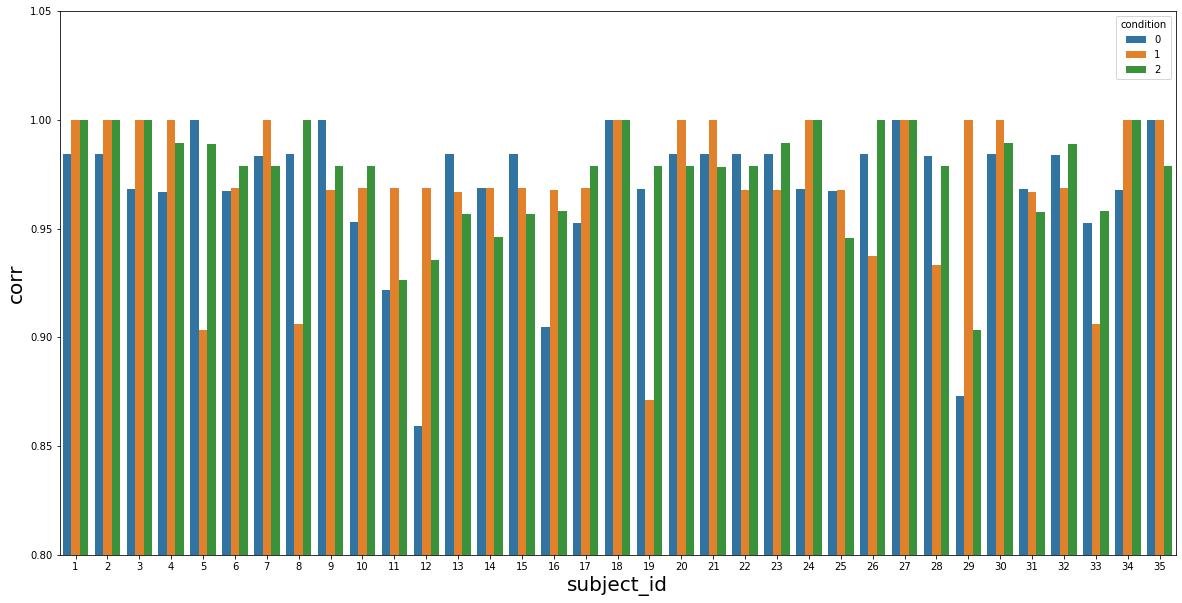

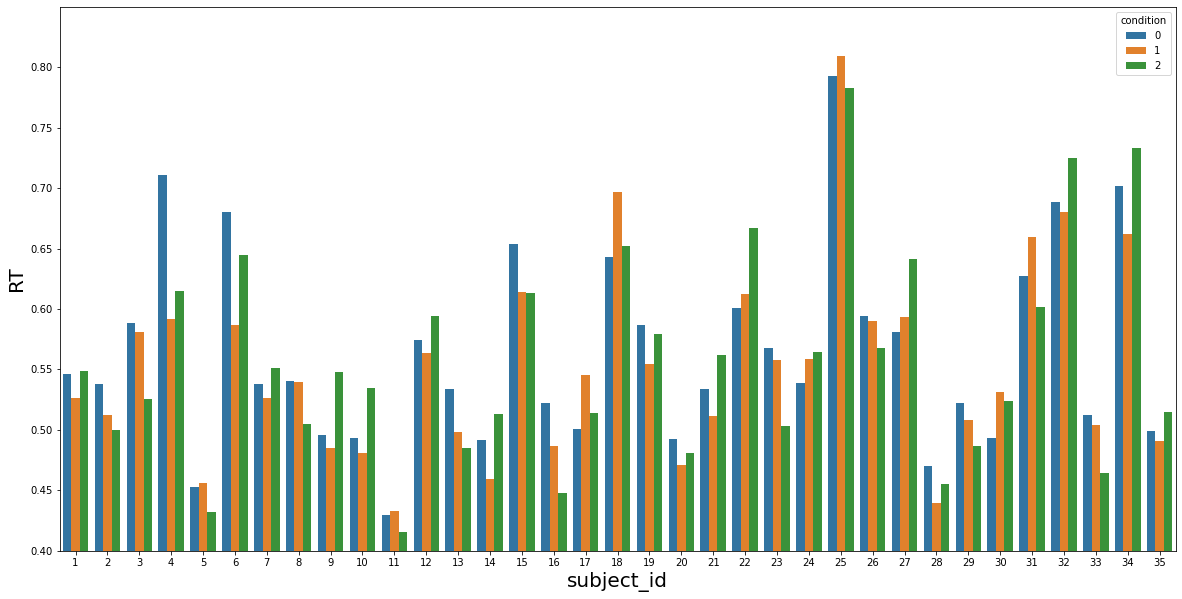

In [6]:
# plotting raw data

# accuracy
plt.figure(figsize=(20, 10))
plt.rc('axes', labelsize = 20)
sns.barplot(data= outlier_dropped_df, x='subject_id', y='corr', hue = 'condition', errorbar=None)
plt.ylim(bottom=0.8)
plt.show()

# reaction time
plt.figure(figsize=(20, 10))
plt.rc('axes', labelsize = 20)
sns.barplot(data= outlier_dropped_df, x='subject_id', y='RT', hue='condition', errorbar=None)
plt.ylim(bottom=0.4)
plt.show()

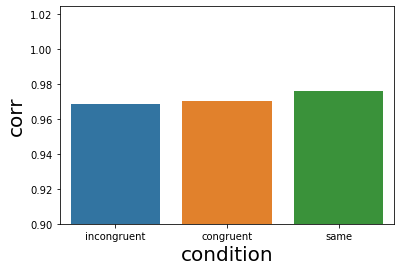

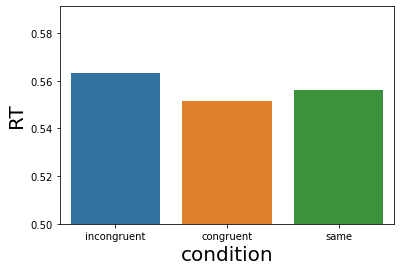

In [7]:
sns.barplot(data = outlier_dropped_df, x = 'condition', y = 'corr', errorbar = None)
plt.xticks([0, 1, 2], ['incongruent', 'congruent', 'same'])
plt.ylim(bottom=0.9)
plt.show()

sns.barplot(data = outlier_dropped_df, x = 'condition', y = 'RT', errorbar = None)
plt.xticks([0, 1, 2], ['incongruent', 'congruent', 'same'])
plt.ylim(bottom=0.5)
plt.show()

<ipython-input-8-f3bb447dfd33>:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = filtered_df, x ='trial', y='RT', palette='bright', errorbar=None)


<AxesSubplot:xlabel='trial', ylabel='RT'>

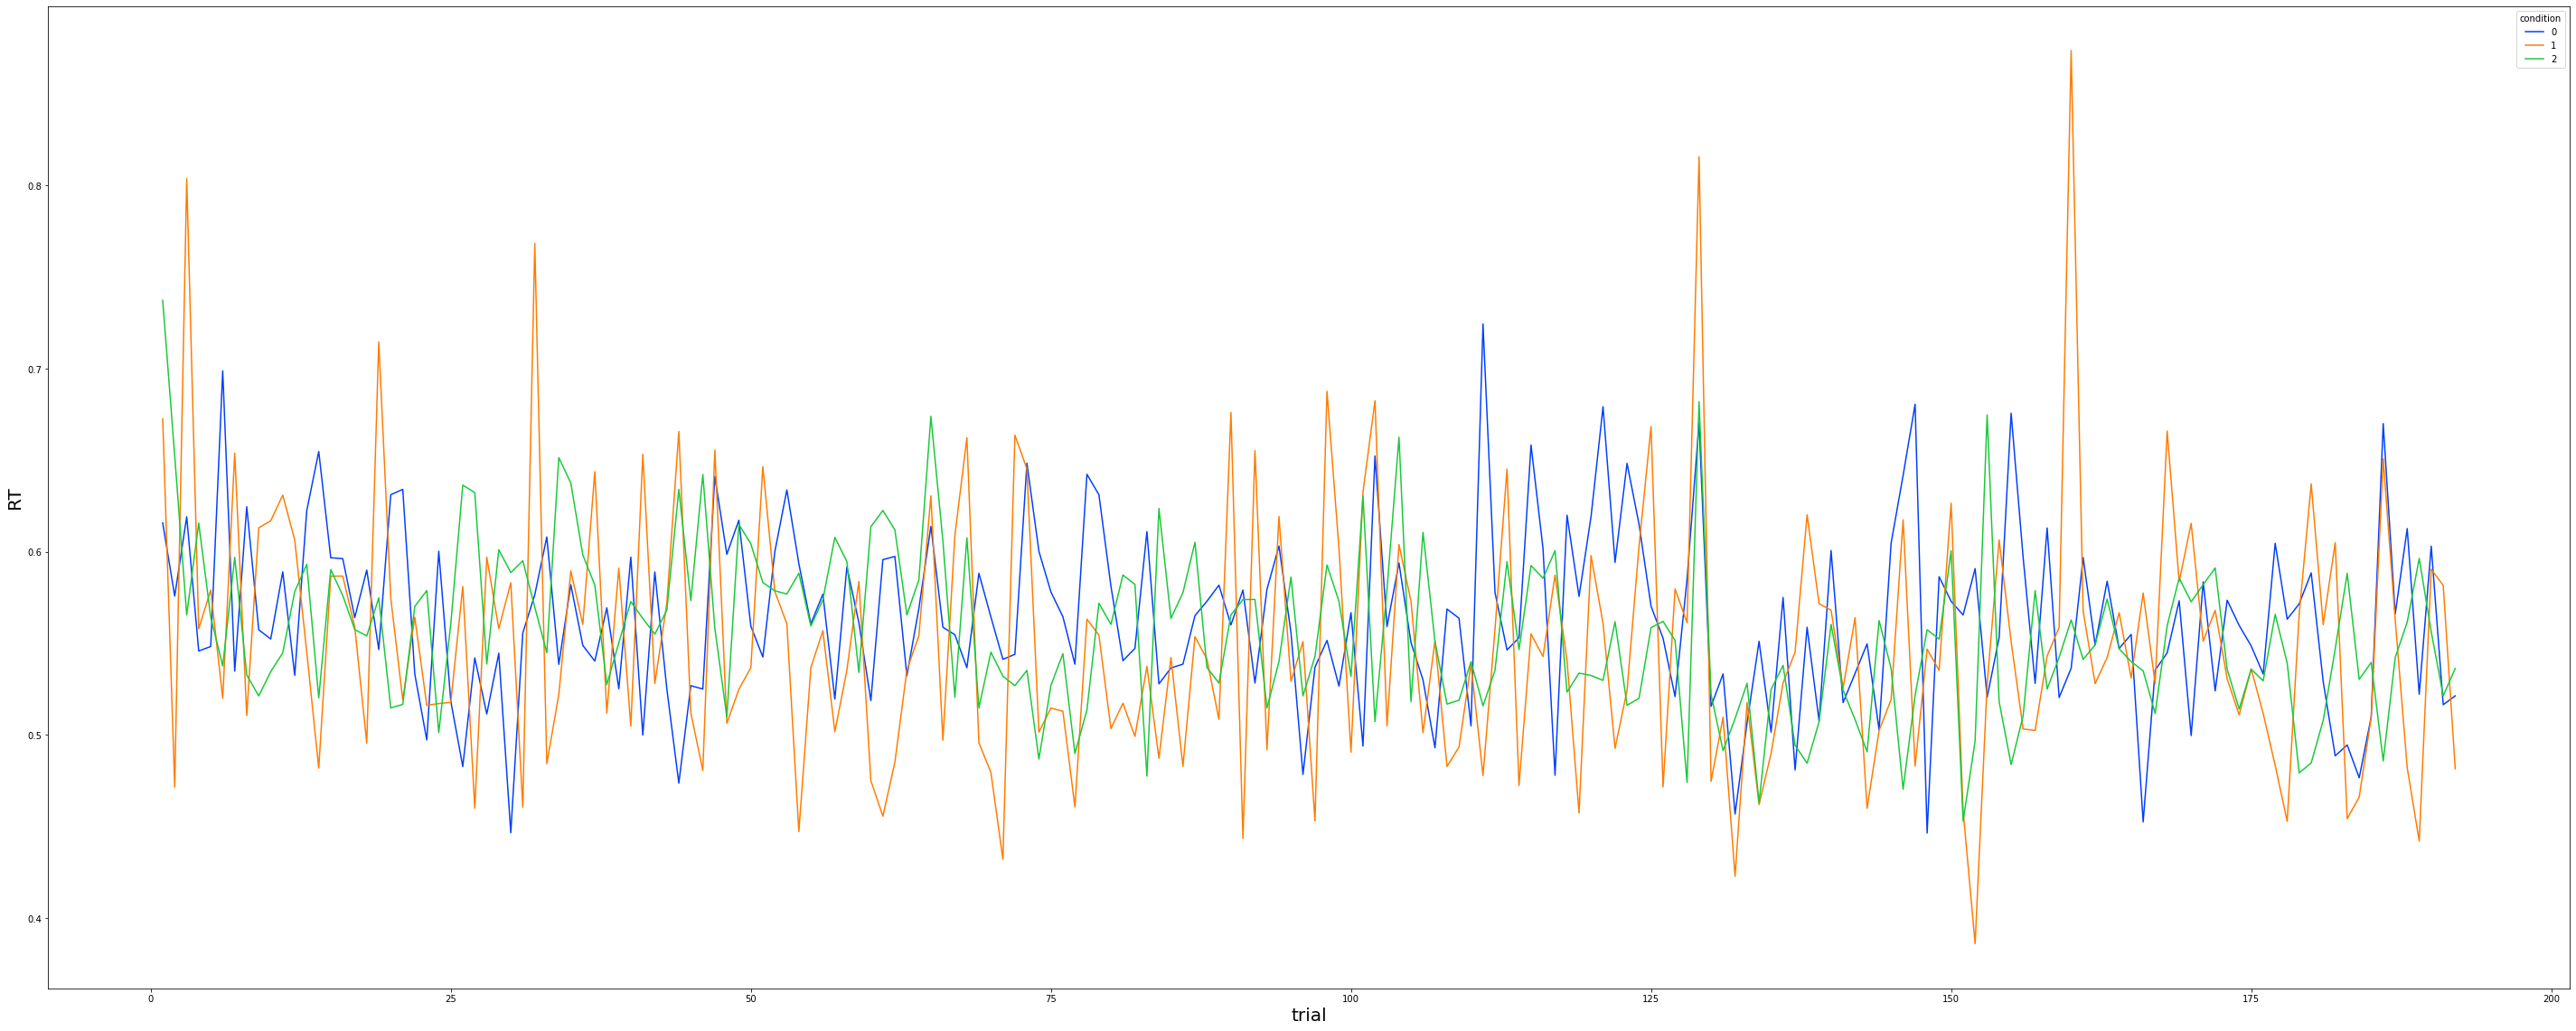

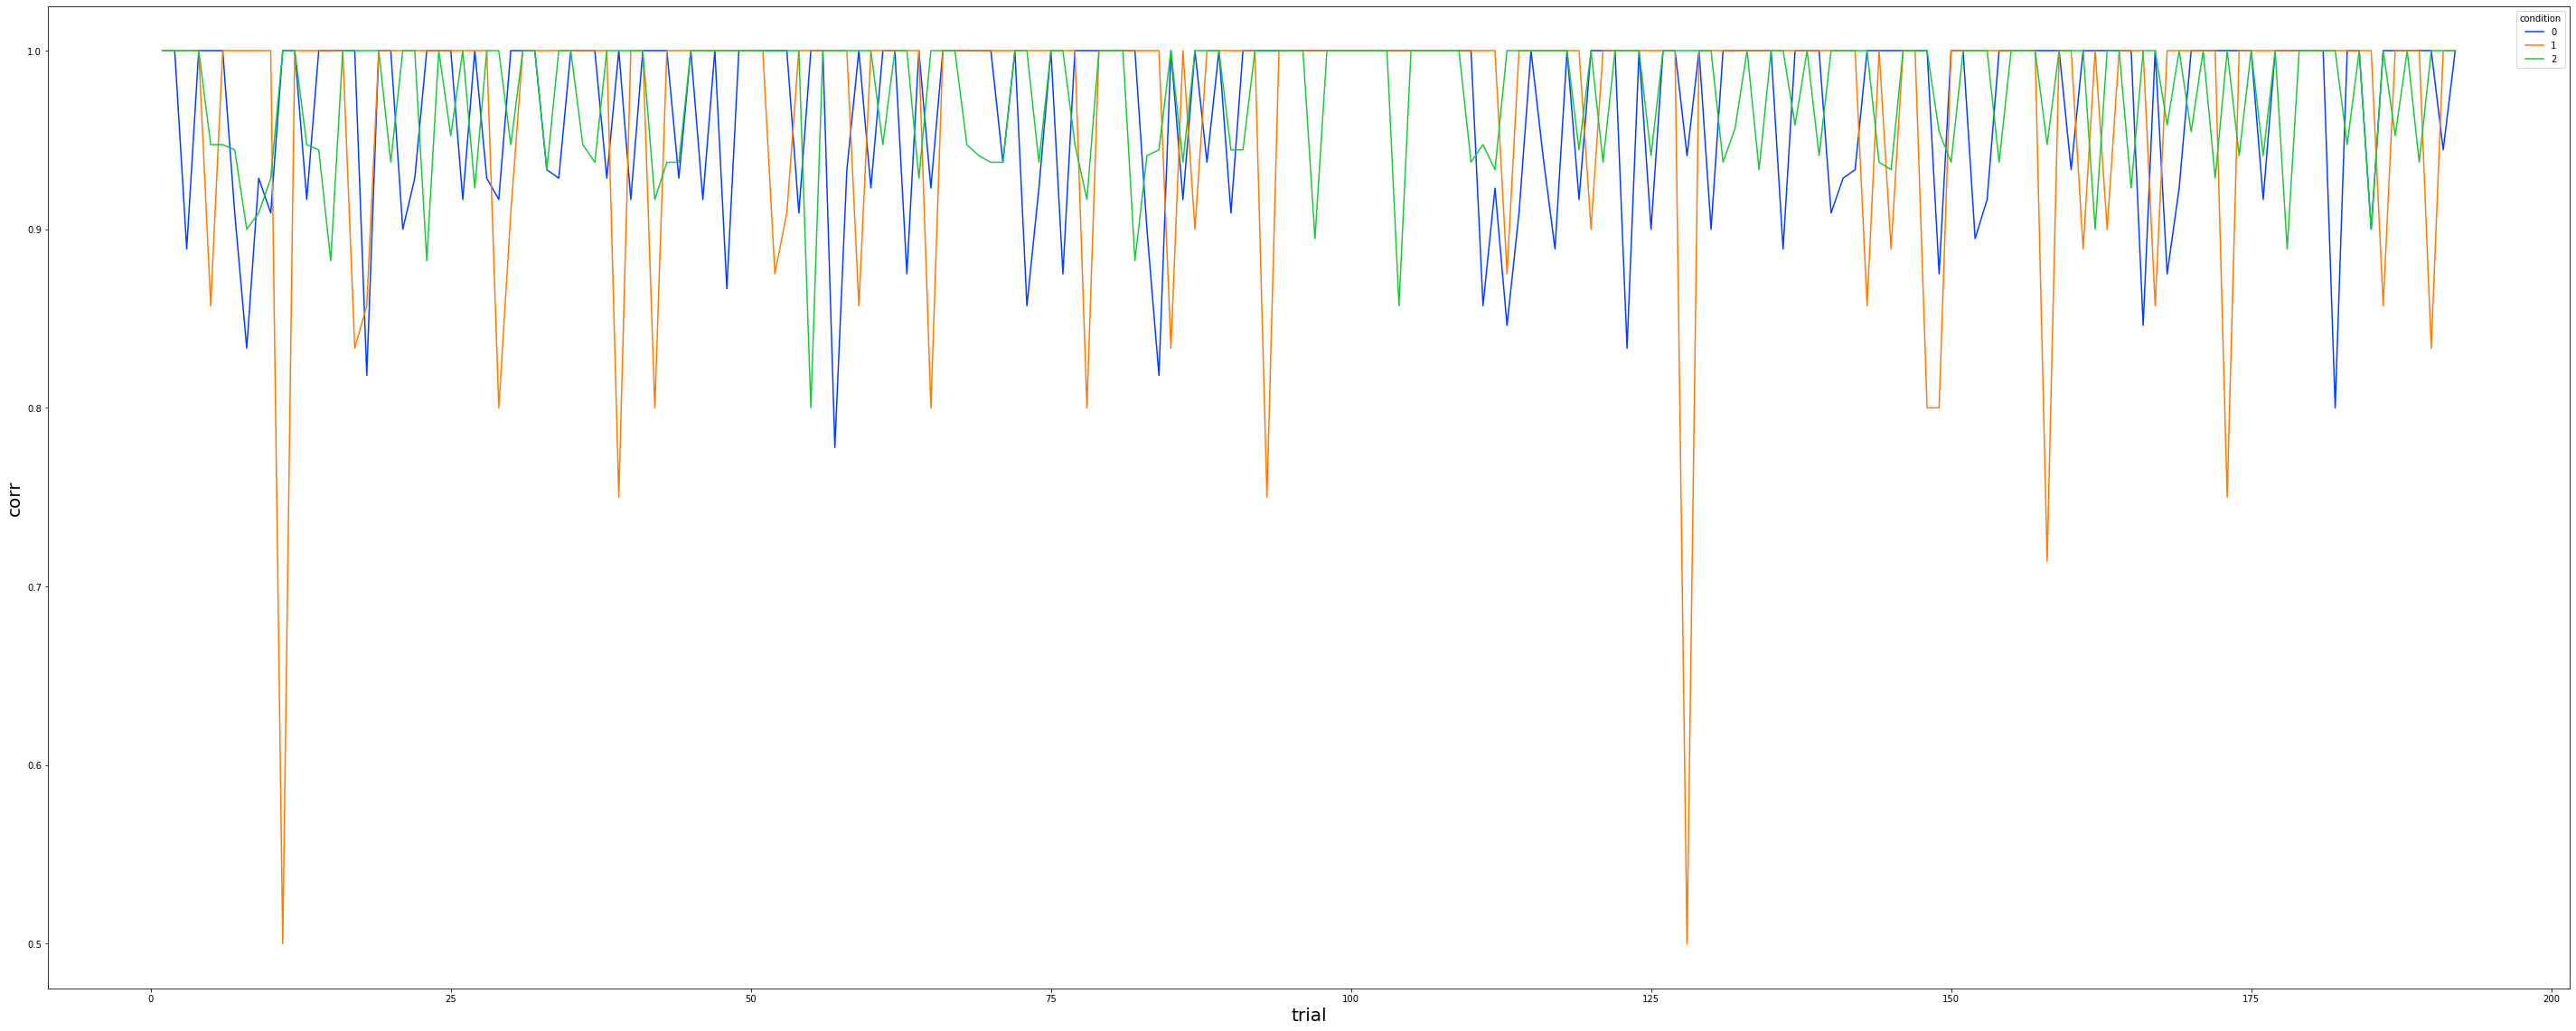

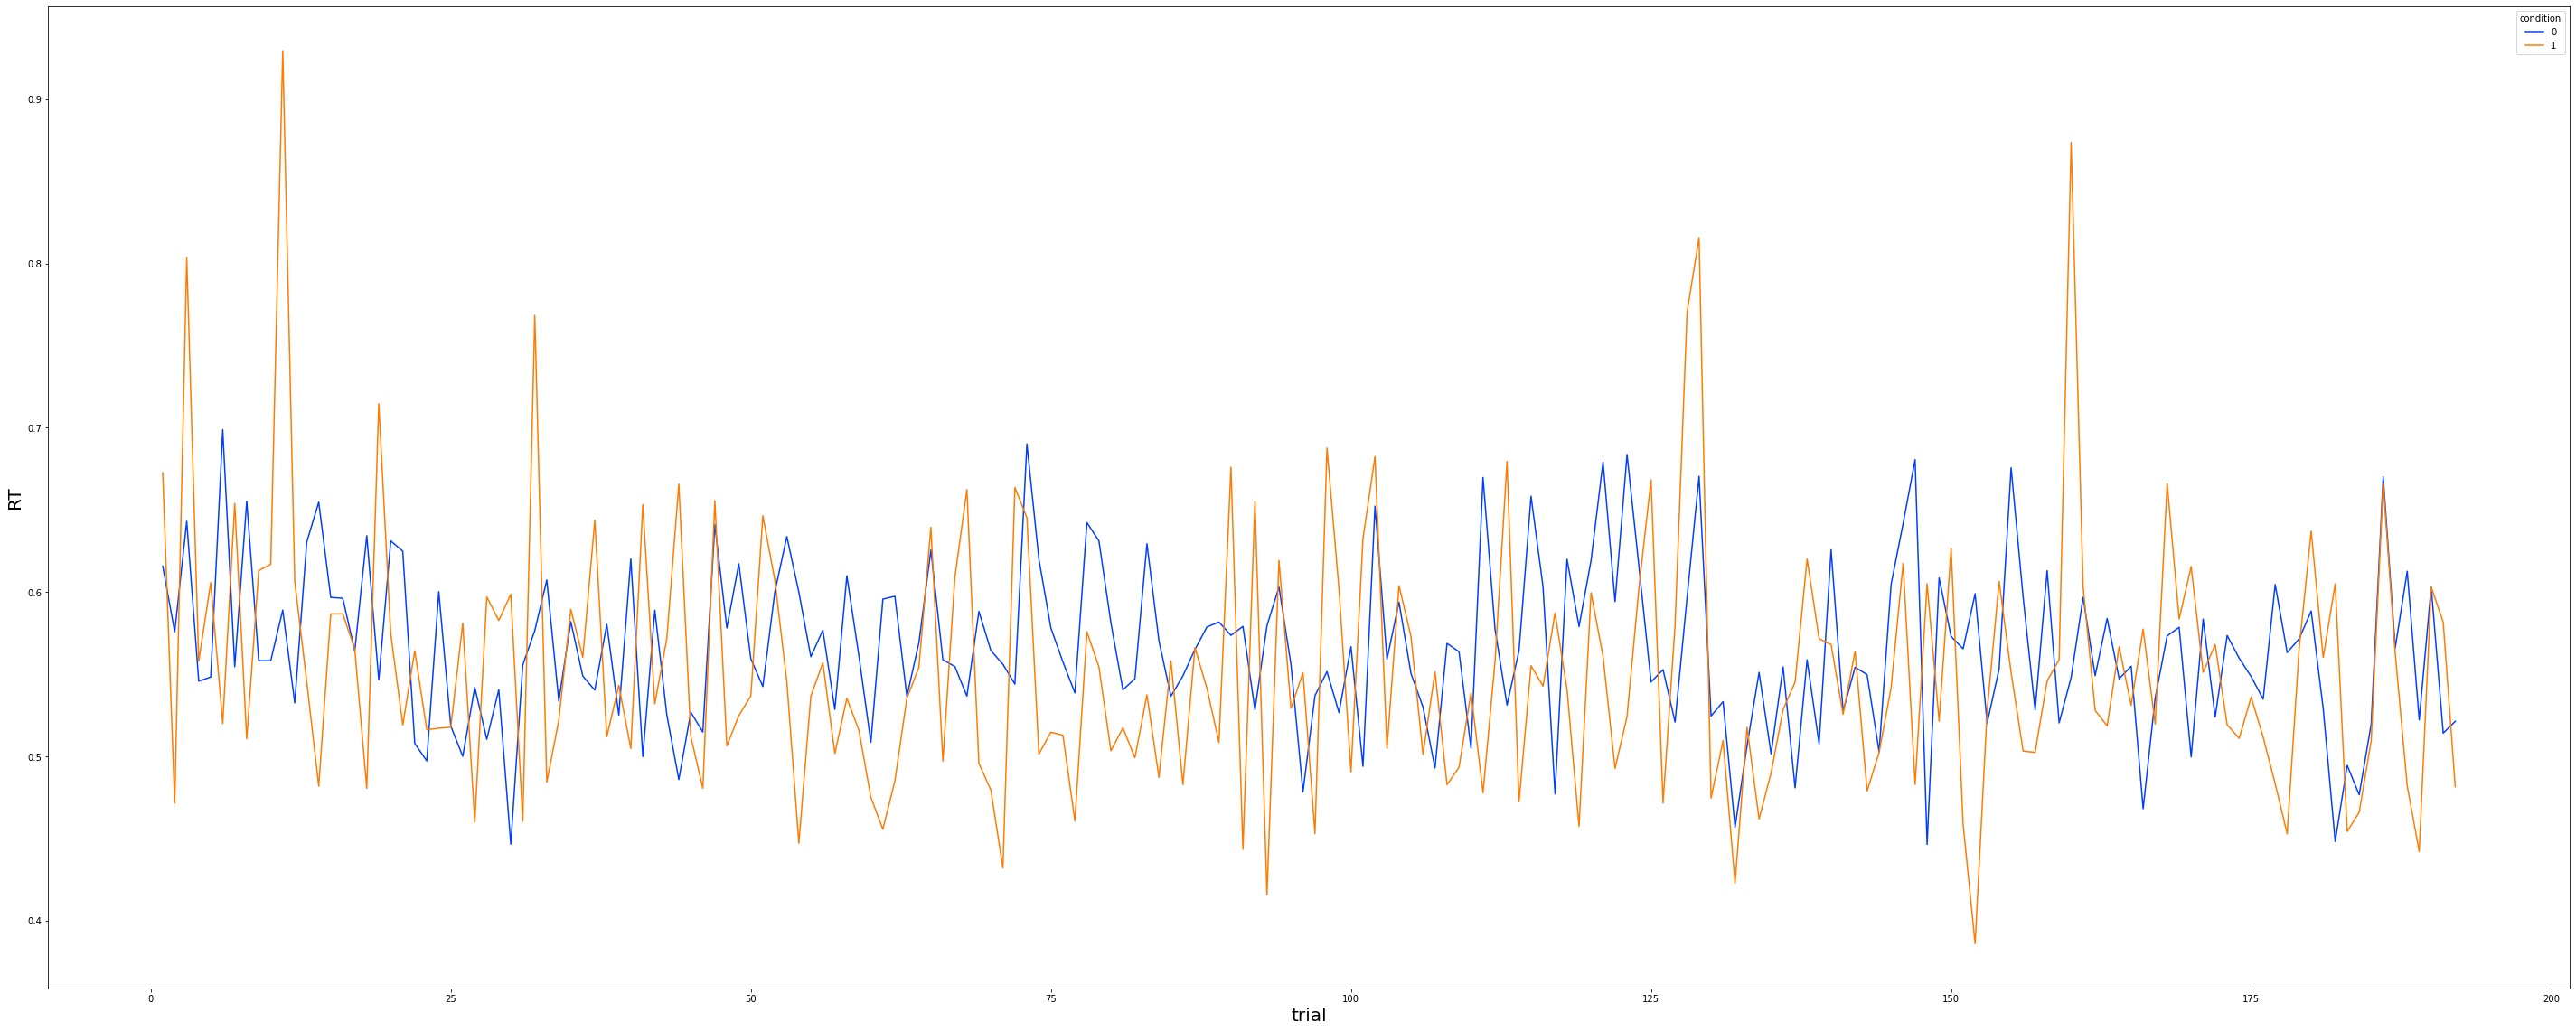

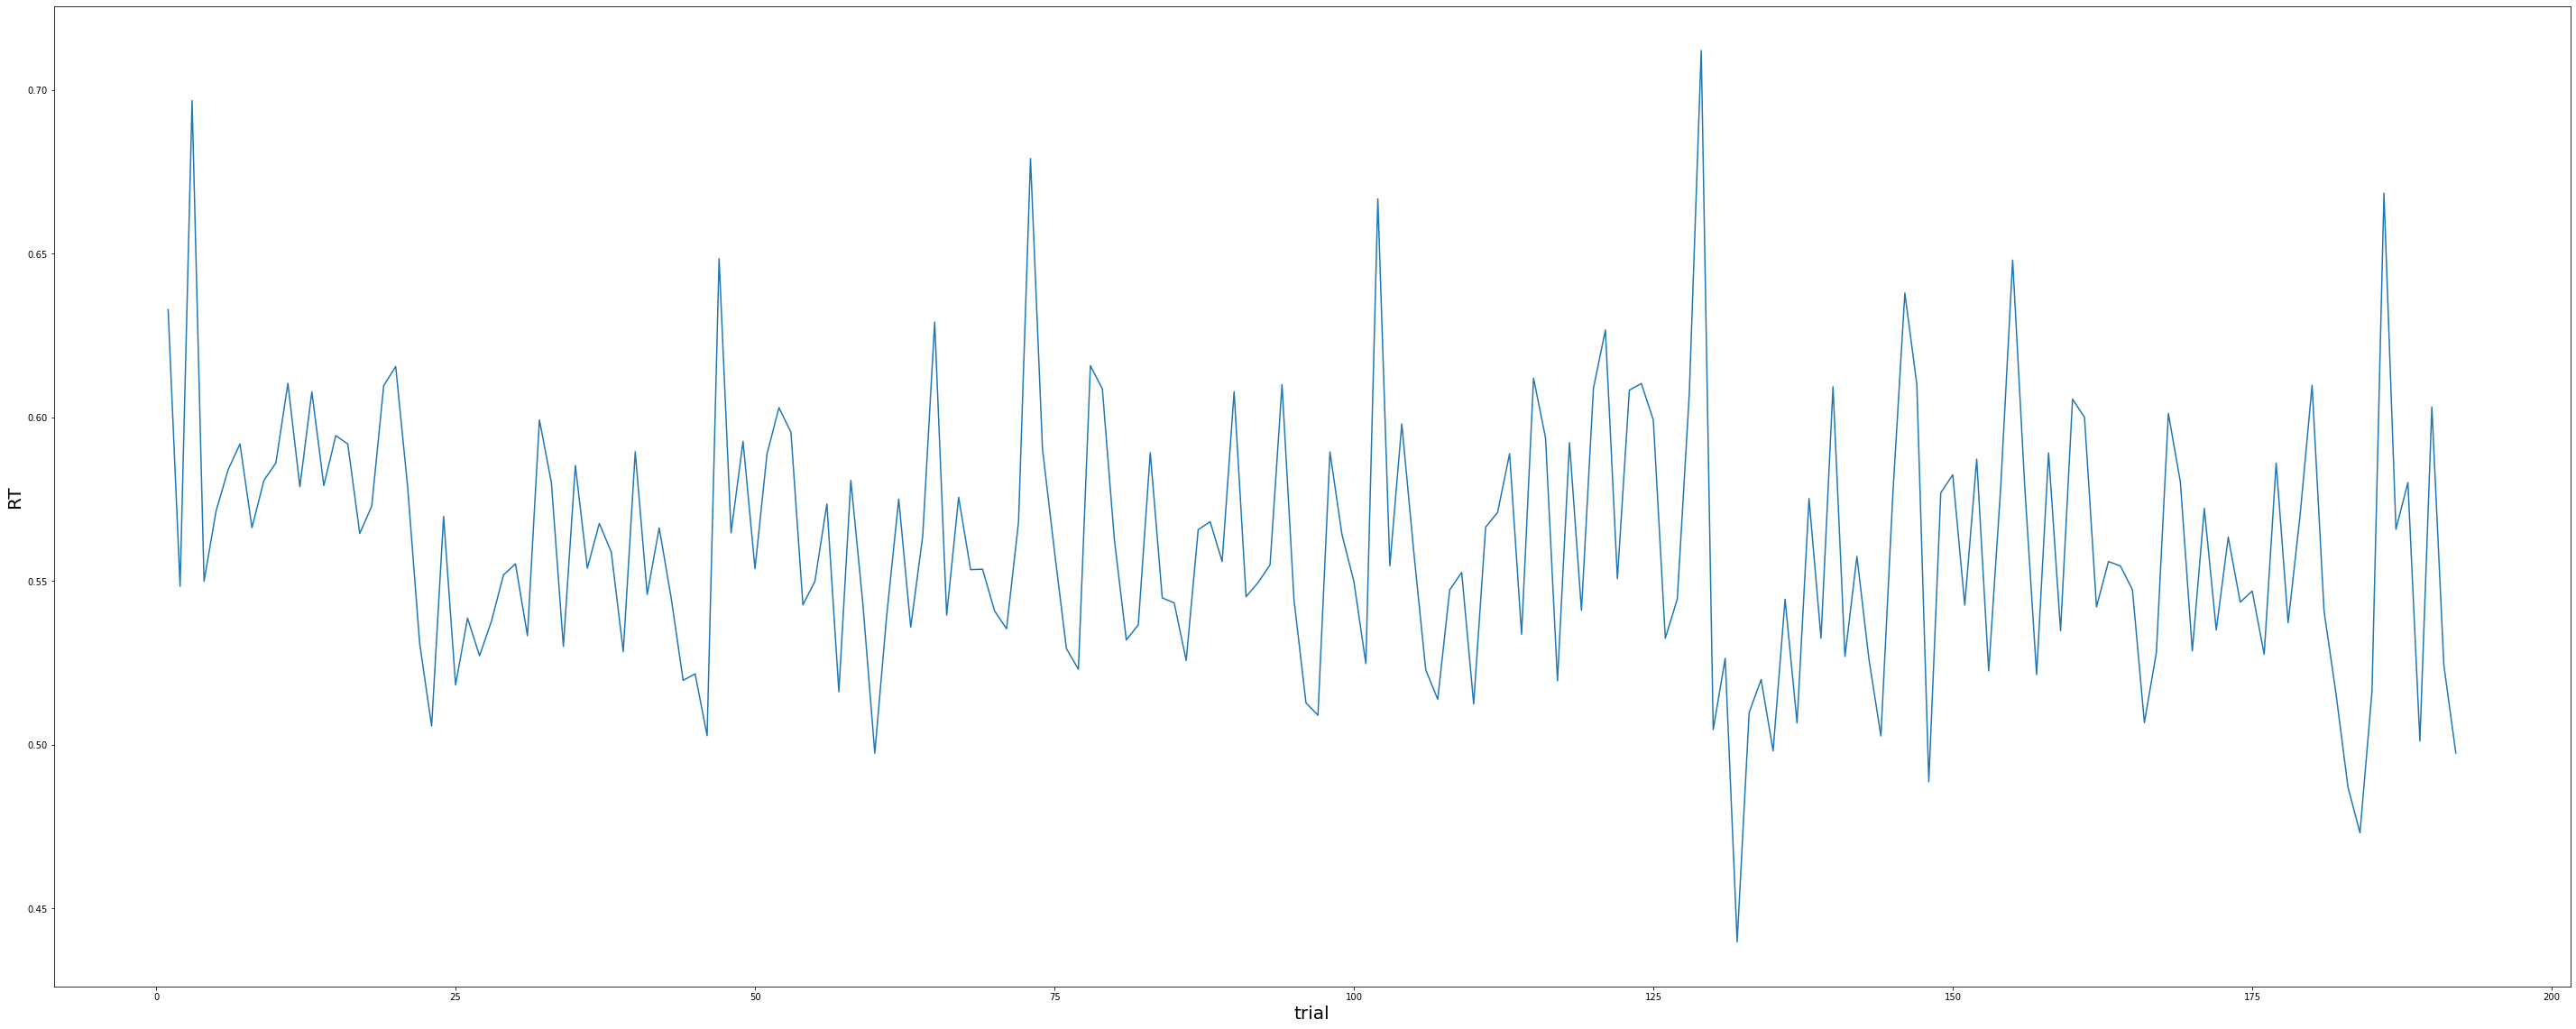

In [8]:
#line plot

plt.figure(figsize=(50, 20))
plt.rc('axes', labelsize = 20)
sns.lineplot(data = outlier_dropped_df, x ='trial', y='RT', hue = 'condition', palette='bright', errorbar=None)

plt.figure(figsize=(50, 20))
plt.rc('axes', labelsize = 20)
sns.lineplot(data = outlier_dropped_df, x ='trial', y='corr', hue = 'condition', palette='bright', errorbar=None)

plt.figure(figsize=(50, 20))
plt.rc('axes', labelsize = 20)
sns.lineplot(data = filtered_df, x ='trial', y='RT', hue = 'condition', palette='bright', errorbar=None)

plt.figure(figsize=(50, 20))
plt.rc('axes', labelsize = 20)
sns.lineplot(data = filtered_df, x ='trial', y='RT', palette='bright', errorbar=None)

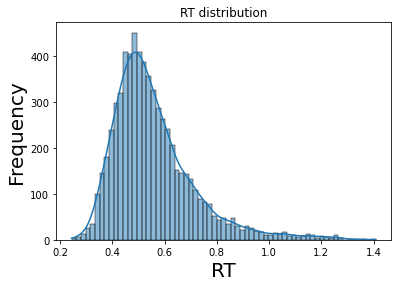

In [9]:
# raw data distribution
sns.histplot(outlier_dropped_df['RT'], kde=True)
plt.title('RT distribution')
plt.xlabel('RT')
plt.ylabel('Frequency')
plt.show()

In [10]:
model = smf.mixedlm('RT ~ condition', filtered_df, groups = filtered_df['subject_id'])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RT       
No. Observations: 3193    Method:             REML     
No. Groups:       35      Scale:              0.0183   
Min. group size:  84      Log-Likelihood:     1788.9155
Max. group size:  96      Converged:          Yes      
Mean group size:  91.2                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.566    0.014 41.601 0.000  0.539  0.592
condition    -0.013    0.005 -2.468 0.014 -0.023 -0.003
Group Var     0.006    0.011                           



C:\Users\user\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


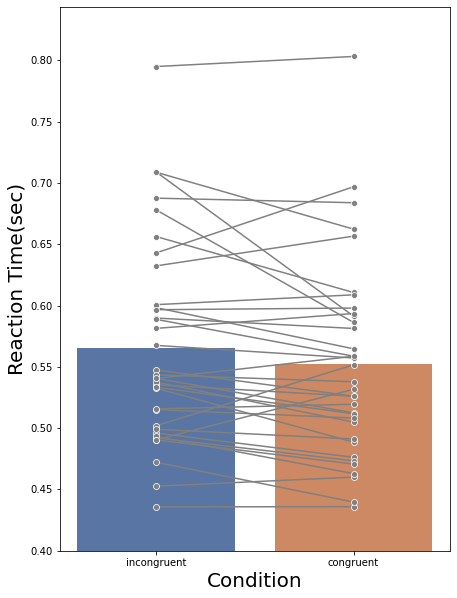

In [11]:
plt.figure(figsize=(7, 10))

# plot overall RT barplot
condition_stats = filtered_df.groupby('condition')['RT'].agg(['mean',]).reset_index()
sns.barplot(data=condition_stats, x='condition', y='mean', palette='deep')

# plot lines for each subject
subject_condition_means = filtered_df.groupby(['subject_id', 'condition'])['RT'].mean().reset_index()
subjects = subject_condition_means['subject_id'].unique()
conditions = subject_condition_means['condition'].unique()
for subject in subjects:
    # Filter the DataFrame for the current subject
    subject_df = subject_condition_means[subject_condition_means['subject_id'] == subject]
    # Plot the line
    sns.lineplot(data=subject_df, x='condition', y='RT', label=subject, color='gray', marker='o', legend=False)

plt.rc('axes', labelsize = 20)
plt.xlabel('Condition')
plt.ylabel('Reaction Time(sec)')
plt.xticks([0, 1], ['incongruent', 'congruent'])
plt.ylim(bottom=0.4)
plt.show()

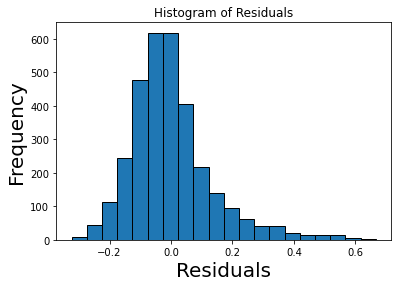

Shapiro-Wilk test statistic: 0.9210643172264099, p-value: 5.232180537522488e-38


In [12]:
# normality test
residuals = result.resid
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

In [13]:
filtered_df.to_csv('result.csv', index=False)